<a href="https://colab.research.google.com/github/RoseGH20/apiBO/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install gpytorch
!pip install botorch

In [2]:
!git clone https://github.com/PV-Lab/Benchmarking.git
!git clone https://github.com/RoseGH20/apiBO.git

Cloning into 'Benchmarking'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 197 (delta 3), reused 1 (delta 1), pack-reused 193 (from 1)
Receiving objects: 100% (197/197), 6.71 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Cloning into 'apiBO'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 136 (delta 69), reused 76 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (136/136), 3.75 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [4]:
import botorch
from datetime import datetime
import gpytorch
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import warnings

from apiBO.utils.utils_matsci import (
    check_config,
    get_grouped_df,
    get_prior_mean,
    get_prior_std,
    create_prior,
    vis_results,
    vis_paper_results)
from apiBO.utils.dataset_configs import agnp, auto_am, cb

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils.transforms import standardize, normalize
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf, optimize_acqf_discrete
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

%matplotlib inline

In [39]:
# Available datasets: agnp, auto_am, cb

config = {"dataset": auto_am, "nrep": 20, "strategy": ["vbo", "pbi", "pibo", "apibo"], "alpha": 0.75, "prior_std": 0.2}

# Note: the parameter "nrep" controls the number of repetitions and also affects the quality of the prior categories.
# If nrep=1, only the best and worst points are included in the good and misleading categories, respectively.
# If nrep=20, the 20 best points and the 20 worst points will be included in the good and misleading categories,
# respectively.

check_config(config)

A value was not specified for beta, setting it to min(n_iters/10, 5) = 3.0.
Using default number of initial random points, nrnd = 3.


Normalized L1 distance from the optimum for all sampled points in the search space.

Text(0.5, 1.0, 'AutoAM')

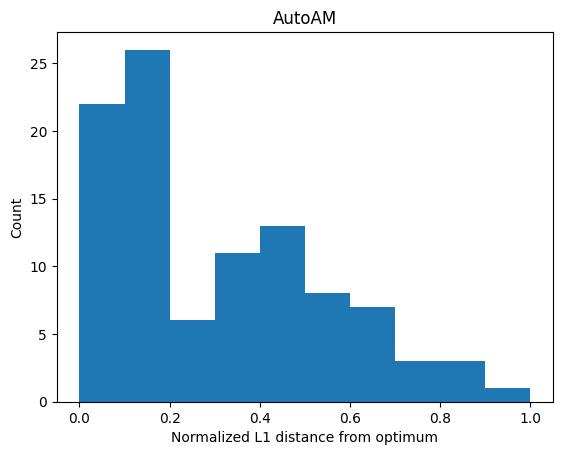

In [40]:
df = pd.read_csv(config["dataset"]["path"])

if config["dataset"]["name"]=="AgNP":
  df['loss'] = df['loss']*-1
  df['loss'] = df['loss'] + np.abs(df['loss'].min())

grouped_df = get_grouped_df(df, config["dataset"]["name"])
norm_grouped_df=(grouped_df-grouped_df.min())/(grouped_df.max()-grouped_df.min())
optim_pos = norm_grouped_df[norm_grouped_df['gt_mean']==norm_grouped_df['gt_mean'].max()].values[0,:-1]
all_dist = np.sum(np.abs(optim_pos - norm_grouped_df.iloc[:,:-1].values), axis =1)
all_dist = all_dist/np.max(all_dist)

plt.hist(all_dist)
plt.ylabel('Count')
plt.xlabel('Normalized L1 distance from optimum')
plt.title(config["dataset"]["name"])

### Optimization

In [36]:
warnings.filterwarnings("ignore")
# mutes legacy_ei_numerics_warning, we have a discrete search space

np.random.seed(1)
torch.manual_seed(1)

X_test = grouped_df.iloc[:,:-1].values
X_test = torch.from_numpy(X_test)
X_test = X_test.double()

n_iters = config["dataset"]["n_iters"]
n_rnd = config["nrnd"]
n_rep = config["nrep"]

space_size = grouped_df.shape[0]
space_dim = grouped_df.shape[1]-1

rand_idx = np.zeros((n_rep, n_rnd), dtype=int)
for r in range(n_rep):
  rand_idx[r] = np.random.permutation(np.arange(space_size))[:n_rnd]

P_test_x = torch.zeros((len(config["strategy"]), 2, n_rep, space_dim, n_iters), dtype=torch.float64)
P_test_y = torch.zeros((len(config["strategy"]), 2, n_rep, 1, n_iters), dtype=torch.float64)
best_pred_y = torch.zeros((len(config["strategy"]), 2, n_rep, 1, n_iters), dtype=int)
perf_explo = np.zeros((len(config["strategy"]), 2, n_rep, n_iters))


for s, strat in enumerate(config["strategy"]):

  if strat == "vbo":
    n_prior_cond = 1

  else:
    n_prior_cond = 2
    prior_cond = ["good","misleading"]

  print("Strategy: ", strat)

  for pc in range(n_prior_cond):

    if strat!="vbo":

      print("Prior quality: ", prior_cond[pc])

    for r in tqdm(range(n_rep)):

      if config["dataset"]["name"] == "AutoAM":

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        # no noise
        likelihood.noise = 1e-4
        likelihood.noise_covar.raw_noise.requires_grad_(False)

      queried_loc = []

      if strat !="vbo":
        idx, d = get_prior_mean(all_dist, prior_cond[pc], r, config["dataset"]["name"])
        std = get_prior_std(X_test, prior_std_perc = config["prior_std"])
        prior = create_prior(X_test[idx], std, X_test)
        prior += 1e-12 # small constant added as suggested for piBO to prevent zeros

        if strat == "apibo":
          # with a-piBO, the prior is min-max normalized
          prior_norm = (prior-np.min(prior))/(np.max(prior)-np.min(prior))

      for i in range(n_iters):

        if i < n_rnd:
          # initial random queries
          next_x_idx = rand_idx[r,i]
          next_x = X_test[next_x_idx]

        else:
          mu_sample_opt = torch.max(train_y)
          EI = ExpectedImprovement(gp, best_f = mu_sample_opt)
          ei_val = EI(X_test[:, None, :])

          if strat!="vbo" and i==n_rnd:
            # for PBI, a-piBO and piBO the first query after the random
            # initialization is the mean of the prior
            af_val = np.zeros(len(ei_val))
            af_val[idx] = 1.0

          elif strat =="pibo":
            af_val = ei_val.detach().numpy()*(prior**(config["beta"]/(i-n_rnd)))

          elif strat =="apibo":
            ei_val = ei_val.detach().numpy()

            if np.all(ei_val==0):
              ei_norm = ei_val.copy()
            else:
              # with a-piBO, the acquisition function is min-max normalized
              ei_norm = (ei_val-np.min(ei_val))/(np.max(ei_val)-np.min(ei_val))

            af_val = ei_norm*((prior_norm*config["alpha"])+(1-config["alpha"]))

          else:
            af_val = ei_val.detach().numpy()

          next_x_idx = np.where(af_val==af_val.max())[0]

          if len(next_x_idx)>1:
            temp = np.random.permutation(next_x_idx)
            next_x_idx = temp[0]
          else:
            next_x_idx = next_x_idx[0]

          next_x = X_test[next_x_idx]

        # get (noisy) response
        resp = config["dataset"]["fct"](X_test[next_x_idx], df)
        queried_loc.append(next_x_idx)
        P_test_x[s, pc, r,:,i] = next_x
        P_test_y[s, pc, r,0,i] = resp
        train_x = P_test_x[s, pc, r,:,:int(i+1)]
        train_x = train_x.T
        train_y = P_test_y[s, pc, r,0,:int(i+1)]
        train_y = train_y[...,np.newaxis]
        train_y = standardize(train_y)

        if config["dataset"]["name"] == "AutoAM":
          gp = SingleTaskGP(train_x, train_y, likelihood = likelihood)
        else:
          gp = SingleTaskGP(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # For a point to be considered the best, it must have been previously queried.
        gp_mean_pred = gp.posterior(X_test).mean.flatten()
        not_queried_loc = np.setdiff1d(np.arange(space_size), queried_loc)
        gp_mean_pred[not_queried_loc] = -np.inf
        best_pred_y[s, pc, r, 0, i] = torch.argmax(gp_mean_pred).item()

        # The performance metric is the ground truth value at the predicted best divided
        # by the ground truth value at the optimum
        perf_explo[s, pc,r,i] = grouped_df.iloc[best_pred_y[s, pc, r, 0, i].item()]["gt_mean"]

gt_best_val = grouped_df["gt_mean"].max()
perf_explo = perf_explo/gt_best_val

now = datetime.now()
now.strftime("%m%d%Y%H%M%S")
np.savez("matSci_{}_ei_{}".format(config["dataset"]["name"], datetime.now().strftime("%m%d%Y%H%M%S")),
         P_test_x = P_test_x, P_test_y = P_test_y, best_pred_y = best_pred_y, perf_explo = perf_explo,
         rand_idx = rand_idx, config = config)

Strategy:  vbo


100%|██████████| 20/20 [05:48<00:00, 17.45s/it]


Strategy:  pbi
Prior quality:  good


100%|██████████| 20/20 [07:06<00:00, 21.30s/it]


Prior quality:  misleading


100%|██████████| 20/20 [06:26<00:00, 19.30s/it]


Strategy:  pibo
Prior quality:  good


100%|██████████| 20/20 [06:41<00:00, 20.06s/it]


Prior quality:  misleading


100%|██████████| 20/20 [05:24<00:00, 16.22s/it]


Strategy:  apibo
Prior quality:  good


100%|██████████| 20/20 [06:55<00:00, 20.75s/it]


Prior quality:  misleading


100%|██████████| 20/20 [05:32<00:00, 16.62s/it]


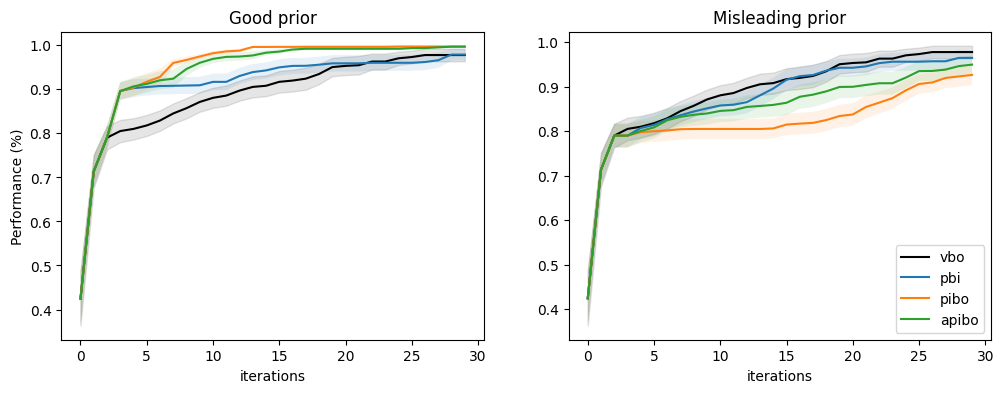

In [33]:
vis_results(perf_explo, config)

### Crossed Barrel

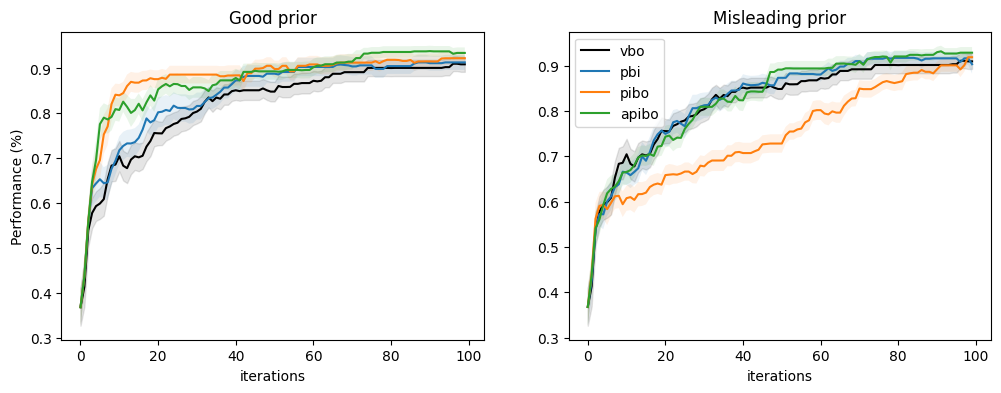

In [ ]:
vis_paper_results(['apiBO/results/matSci_CB_vbo_ei.npz', 'apiBO/results/matSci_CB_pbi_ei.npz',
             'apiBO/results/matSci_CB_pibo_ei.npz', 'apiBO/results/matSci_CB_apibo_ei.npz'])

### AutoAM

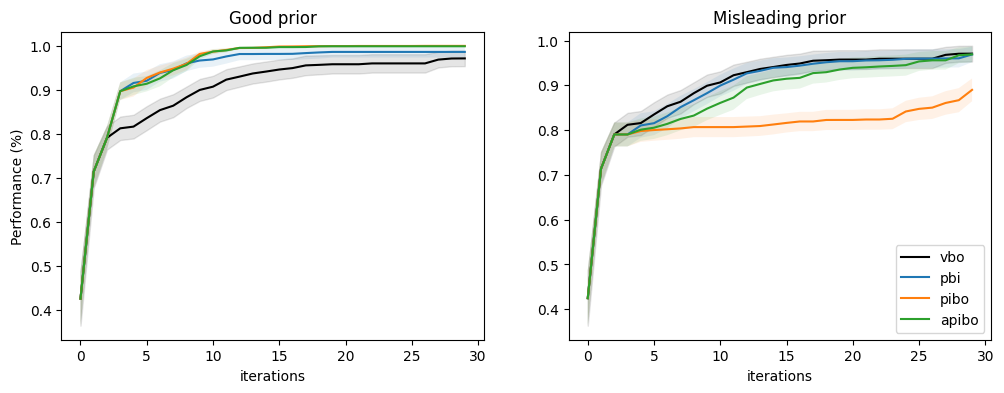

In [ ]:
vis_paper_results(['apiBO/results/matSci_AutoAM_vbo_ei.npz', 'apiBO/results/matSci_AutoAM_pbi_ei.npz',
             'apiBO/results/matSci_AutoAM_pibo_ei.npz', 'apiBO/results/matSci_AutoAM_apibo_ei.npz'])

### AgNP

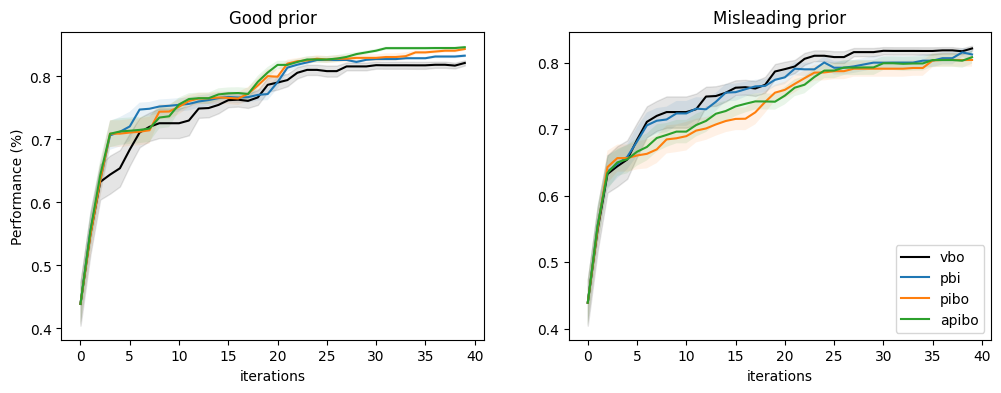

In [ ]:
vis_results(['apiBO/results/matSci_AgNP_vbo_ei.npz', 'apiBO/results/matSci_AgNP_pbi_ei.npz',
             'apiBO/results/matSci_AgNP_pibo_ei.npz', 'apiBO/results/matSci_AgNP_apibo_ei.npz'])